# Human-in-the-Loop Machine Learning: Final Project

In [1]:
# imports
import datasets
from openai import OpenAI
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data_utils import openai_iter_generation, get_demographic_system_prompt, get_annotator_demographic_dict, get_majority_vote, get_ds_format
from data_info import comment_annotations
from dawid_skene import run

### 1. Loading the dataset from huggingface

In [2]:
# !pip install datasets

In [3]:
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'default') 

In [4]:
# dataset['train'][0]

### 2. OpenAI API Setup and Test

In [5]:
## Set the API key and model name
# api_key = open("openai_api_key.txt", 'r').read() # API key needs to be in this txt file
# MODEL="gpt-4o-mini"
# client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", api_key))

In [6]:
# completion = client.chat.completions.create(
#   model=MODEL,
#   messages=[
#     {"role": "system", "content": "You are a helpful assistant. Help me with my math homework!"}, # <-- This is the system message that provides context to the model
#     {"role": "user", "content": "Hello! Could you solve 2+2?"}  # <-- This is the user message for which the model will generate a response
#   ]
# )

# print("Assistant: " + completion.choices[0].message.content)
# print(completion.choices[0].message)

### 3. Dataset filtering

Here is code for sorting data by comment id, where the most annotated comments are sorted first.

In [7]:
# # filtering the data to the top annotated comments; filters down to about 1/4 of the original dataset
# # first get the number of times a comment was annotated
# comment_ids_annotated = {} # in format {comment_id: #times annotated}
# for instance in tqdm(dataset['train']):
#     if instance['comment_id'] not in comment_ids_annotated:
#         comment_ids_annotated[instance['comment_id']] = 0
#     comment_ids_annotated[instance['comment_id']] += 1
# # then sort the comments in reverse order
# sorted_comment_ids = sorted(comment_ids_annotated.items(), key=lambda item: item[1], reverse=True)

In [8]:
# from comment_annotator_ids import comment_ids_annotated

If we wanted the 50 most annotated comments

In [9]:
# # then get just the comment_ids of the top 50 annotated comments
# top_annotated_50 = []
# for i in range(50):
#     top_annotated_50.append(sorted_comment_ids[i][0])

# previous part was already calculated and these are the top comment_ids
# top_annotated_50 = [20011, 20002, 20001, 20007, 20022, 20014, 20034, 20047, 20068, 20009, 20057, 20010, 20069, 20003, 20017, 20023, 20016, 20060, 20019, 20018, 20020, 20012, 20045, 20021, 20006, 20053, 20004, 20013, 20055, 20064, 20052, 20024, 20059, 20066, 20008, 20056, 20067, 20063, 20062, 20061, 20015, 20049, 20048, 20005, 20065, 20070, 20058, 20054, 20035, 20039]
# top50_dataset = dataset.filter(lambda instance: instance['comment_id'] in top_annotated_50)
# original dataset has 135556 instances and filtered dataset has 35935 instances

Here we sort data by annotator id, where the annotators who annotated most are sorted first.

In [10]:
# # filtering the data to the top annotators
# # first get the number of times an annotator annotated a comment
# annotator_ids_annotated = {} # in format {annotator_id: #times annotated}
# for instance in tqdm(dataset['train']):
#     if instance['annotator_id'] not in annotator_ids_annotated:
#         annotator_ids_annotated[instance['annotator_id']] = 0
#     annotator_ids_annotated[instance['annotator_id']] += 1
# # then sort the comments in reverse order
# sorted_annotator_ids = sorted(annotator_ids_annotated.items(), key=lambda item: item[1], reverse=True)

In [11]:
# from comment_annotator_ids import annotator_ids_annotated

If we wanted the top 50 annotators

In [12]:
# then get just the annotator_ids of the top 50 annotated comments
# top_annotator_50 = []
# for i in range(50):
#     top_annotator_50.append(sorted_annotator_ids[i][0])

# previous part was already calculated and these are the top annotator_ids
# top_annotator_50 = [9563, 3887, 8382, 5525, 8565, 1410, 9202, 4521, 6098, 9955, 8134, 10262, 69, 4791, 4997, 11111, 6321, 3175, 1873, 8276, 6050, 1329, 4047, 7160, 1671, 2553, 1081, 3581, 1826, 266, 6403, 8818, 2471, 10561, 7774, 7660, 10525, 1847, 5144, 9848, 5707, 9178, 3483, 4962, 4431, 3922, 10648, 8832, 1318, 10111]
# top50_dataset = dataset.filter(lambda instance: instance['comment_id'] in top_annotated_50)
# original dataset has 135556 instances and filtered dataset has 35935 instances

Let's say we only want instances where the comments have 5-10 labels and with annotators who have annotated more than 20 instances.

In [13]:
# we first get all annotator ids where they have annotated more than 20 comments
# annotator_ids_20 = [k for k, v in annotator_ids_annotated.items() if v > 19] # this leaves us with 2316 annotators

In [14]:
# # we can then add comments up to 10 times if they have an annotator in the previous list
# times_comment_added = {} # in {comment_id: times_added} format
# comments_up_to_10 = [] # adding in all the comments with the right annotator, up to 10 comments
# for instance in tqdm(dataset['train']):
#     if instance['annotator_id'] in annotator_ids_20:
#         if instance['comment_id'] not in times_comment_added:
#             times_comment_added[instance['comment_id']] = 0
#         if times_comment_added[instance['comment_id']] < 11:
#             times_comment_added[instance['comment_id']] += 1
#             comments_up_to_10.append((instance['comment_id'], instance['annotator_id']))

In [15]:
# # we can then remove all the comments that have less than 5 labels
# filtered_comment_annotator_id = []
# for c_id, a_id in comments_up_to_10:
#     if times_comment_added[c_id] > 4:
#         filtered_comment_annotator_id.append((c_id, a_id))
# # we are then left with 785 instances

We can use just a few examples for the LLM.

In [16]:
# we first get all annotator ids where they have annotated more than 25 comments
# annotator_ids_26 = [k for k, v in annotator_ids_annotated.items() if v > 25] # this leaves us with 21 annotators

In [17]:
# # we can then add comments up to 10 times if they have an annotator in the previous list
# times_comment_added = {} # in {comment_id: times_added} format
# comments_up_to_10 = [] # adding in all the comments with the right annotator, up to 10 comments
# for instance in tqdm(dataset['train']):
#     if instance['annotator_id'] in annotator_ids_26:
#         if instance['comment_id'] not in times_comment_added:
#             times_comment_added[instance['comment_id']] = 0
#         if times_comment_added[instance['comment_id']] < 11:
#             times_comment_added[instance['comment_id']] += 1
#             comments_up_to_10.append((instance['comment_id'], instance['annotator_id']))

In [18]:
# # we can then remove all the comments that have less than 5 labels
# llm_filtered_comment_annotator_id = []
# for c_id, a_id in comments_up_to_10:
#     if times_comment_added[c_id] > 4:
#         llm_filtered_comment_annotator_id.append((c_id, a_id))
# # we are then left with 27 instances

In [19]:
from comment_annotator_ids import llm_filtered_comment_annotator_id

### 3.5 Dataset filtering

In [20]:
from comment_annotator_ids import filtered_comment_annotator_id

In [21]:
filtered_dataset = dataset.filter(lambda instance: (instance['comment_id'], instance['annotator_id']) in filtered_comment_annotator_id)
# we have 785 filtered instances left

In [22]:
unique_comment_ids = list(set([c for c, a in filtered_comment_annotator_id]))
unique_annotator_ids = list(set([a for c, a in filtered_comment_annotator_id]))

In [23]:
comment_id_to_data = {}
for instance in filtered_dataset['train']:
    if instance['comment_id'] not in comment_id_to_data.keys():
        comment_id_to_data[instance['comment_id']] = {'comment': instance['text']}
        for axis in comment_annotations:
            comment_id_to_data[instance['comment_id']][axis] = []
    for axis in comment_annotations:
            comment_id_to_data[instance['comment_id']][axis].append(instance[axis])

### 4. Majority Voting

In [24]:
axes_results = {}
for axis in comment_annotations:
    axes_results[axis] = []

for id in comment_id_to_data:
    results = get_majority_vote(comment_id_to_data[id])
    for axis in comment_annotations:
        axes_results[axis].append(results[axis])

(array([33.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., 40.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        , 1.06666667, 1.13333333, 1.2       , 1.26666667,
        1.33333333, 1.4       , 1.46666667, 1.53333333, 1.6       ,
        1.66666667, 1.73333333, 1.8       , 1.86666667, 1.93333333,
        2.        ]),
 <BarContainer object of 30 artists>)

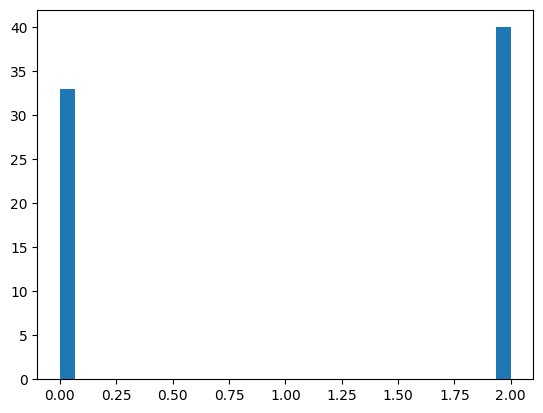

In [25]:
plt.hist(axes_results['hatespeech'], bins=30)

### 5. Dawid-Skene

In [26]:
ds_format_data = {}
for axis in comment_annotations:
    ds_format_data[axis] = get_ds_format(filtered_dataset['train'], axis)

In [27]:
dawid_skene_results = {}
for axis in comment_annotations:
    dawid_skene_results[axis] = run(ds_format_data[axis])

/Users/miriam/Desktop/hitlml-project/dawid_skene.py:228: RuntimeWarning: overflow encountered in divide
  error_rates[k,j,:] = error_rates[k,j,:]/float(sum_over_responses)


In [28]:
dawid_skene_results['sentiment']

{28322: array([0., 0., 1., 0., 0.]),
 45496: array([0., 0., 0., 1., 0.]),
 13827: array([0., 0., 0., 0., 1.]),
 20045: array([0., 0., 0., 0., 1.]),
 20047: array([0., 0., 0., 0., 1.]),
 20070: array([0., 0., 0., 0., 1.]),
 20057: array([0., 0., 0., 0., 1.]),
 20068: array([0., 0., 0., 0., 1.]),
 20001: array([0., 0., 0., 0., 1.]),
 20034: array([0., 0., 0., 0., 1.]),
 20012: array([0., 0., 0., 0., 1.]),
 20002: array([0., 0., 0., 0., 1.]),
 20023: array([0., 0., 0., 0., 1.]),
 20008: array([0., 0., 0., 0., 1.]),
 20007: array([0., 0., 0., 0., 1.]),
 20013: array([0., 0., 0., 0., 1.]),
 20009: array([0., 0., 0., 0., 1.]),
 20006: array([0., 0., 0., 0., 1.]),
 20011: array([0., 0., 0., 0., 1.]),
 20010: array([0., 0., 0., 0., 1.]),
 20004: array([0., 0., 0., 0., 1.]),
 20005: array([0., 0., 0., 0., 1.]),
 20003: array([0., 0., 0., 0., 1.]),
 20015: array([0., 0., 0., 1., 0.]),
 20017: array([0.    , 0.    , 0.    , 0.0001, 0.9999]),
 20021: array([0., 0., 0., 0., 1.]),
 20020: array([0.,

In [29]:
ds_axes_results = {}
for axis in comment_annotations:
    ds_axes_results[axis] = [np.argmax(v) for k, v in dawid_skene_results[axis].items()]

(array([25.,  0.,  0.,  0.,  0.,  0.,  0., 17.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,
         0.,  0.,  0., 14.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

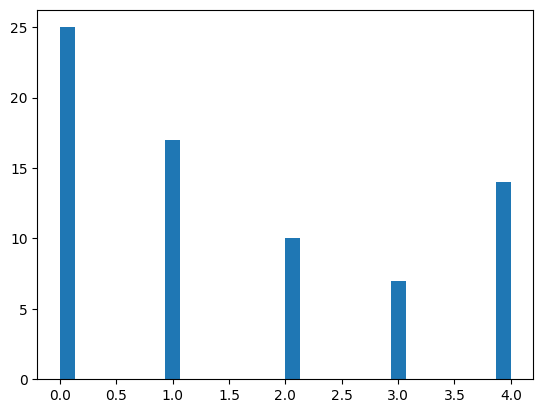

In [38]:
plt.hist(ds_axes_results['violence'], bins=30)

(array([36.,  0.,  0.,  0.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,
         0.,  0.,  0., 13.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

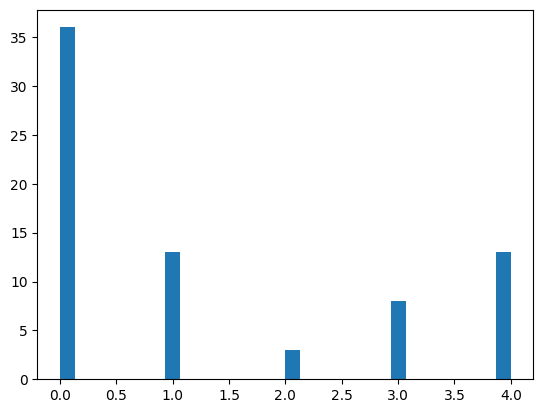

In [39]:
plt.hist(axes_results['violence'], bins=30)

### ???. Testing utils

In [32]:
# api_key = open("openai_api_key.txt", 'r').read() # API key needs to be in this txt file
# model="gpt-4o-mini"
# client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", api_key))
# system = "You are a quiet AI assistant. You respond in very few words."
# user_list = ["How is your day going?", "Are you a fan of green tea?", "Do you know anything about St Paul, MN."]
# responses = openai_iter_generation(client, model, system, user_list)
# responses

In [33]:
# data_instance = filtered_dataset['train'][7]

In [34]:
# axes = ['gender', 'race', 'income', 'educ', 'ideology', 'age', 'sexuality', 'trans', 'religion']
# get_demographic_system_prompt(data_instance, axes)

In [1]:
from comment_annotator_ids import filtered_comment_annotator_id, llm_filtered_comment_annotator_id

In [2]:
unique_comment_ids = list(set([c for c, a in filtered_comment_annotator_id]))
unique_annotator_ids = list(set([a for c, a in filtered_comment_annotator_id]))

In [ ]:
llm_unique_comment_ids = list(set([c for c, a in llm_filtered_comment_annotator_id]))
llm_unique_annotator_ids = list(set([a for c, a in llm_filtered_comment_annotator_id]))

In [5]:
print(len(filtered_comment_annotator_id))
print(len(unique_comment_ids))
print(len(unique_annotator_ids))

785
73
232


In [ ]:
print(len(llm_filtered_comment_annotator_id))
print(len(llm_unique_comment_ids))
print(len(llm_unique_annotator_ids))